## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [3]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [7]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [8]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

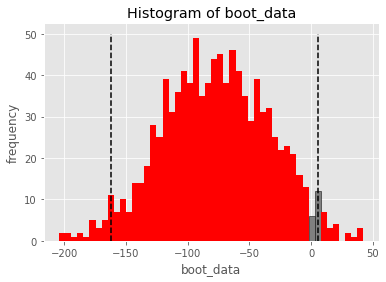

In [9]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [10]:
booted_data["p_value"] # альфа

0.07704553867678232

In [11]:
booted_data["quants"] # ДИ

,0
0.025,-161.943418
0.975,5.328283


In [12]:
data_ab = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [13]:
data_ab.head()

,Unnamed: 0,value,experimentVariant
0,1,9.773113,Treatment
1,2,9.311246,Treatment
2,3,11.172828,Treatment
3,4,11.624510,Treatment
4,5,10.462331,Treatment


In [14]:
data_ab.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [15]:
data_ab.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,50


In [16]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.367236


In [17]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.420193


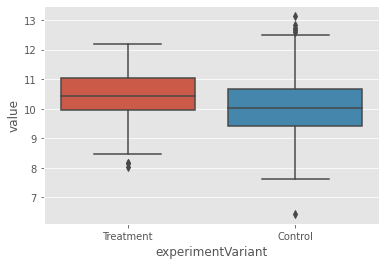

In [18]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


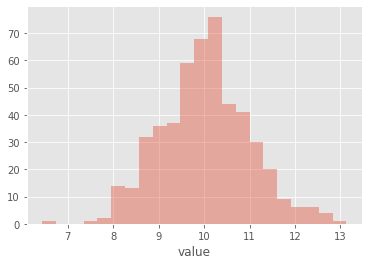

In [19]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

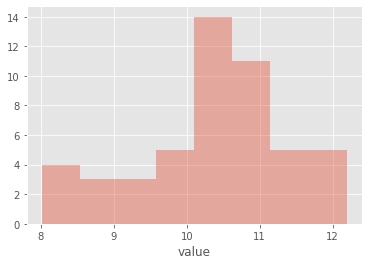

In [20]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

In [21]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=15492.0, pvalue=0.005236419587596797)

In [22]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.3318589655730135, pvalue=0.02006953912735476)

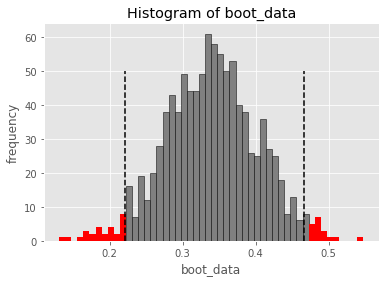

{'boot_data': [0.18776922743289304,
  0.2743838675211076,
  0.3909727989808199,
  0.3904828832226608,
  0.3148571793586496,
  0.3069757794930819,
  0.33629241069251303,
  0.2495038678188318,
  0.28549502999860166,
  0.3264786929742884,
  0.3346640724381806,
  0.20350194545007172,
  0.36711279749907466,
  0.375955783001078,
  0.47637116871403024,
  0.21050188748730733,
  0.3996596272650998,
  0.21706371747252268,
  0.3205050287524081,
  0.2999072255449676,
  0.3451589979116176,
  0.3711652313496435,
  0.487194465404953,
  0.3866340784031173,
  0.4291399125597986,
  0.3559036189255172,
  0.3610108676411263,
  0.2950572590683745,
  0.3110935006794872,
  0.35442805077715595,
  0.34979957789697175,
  0.3667140741186572,
  0.2904463981998922,
  0.42686031890116566,
  0.3416520081021791,
  0.3576769284411188,
  0.3436850660528669,
  0.4083918267424844,
  0.2811616991153623,
  0.37474344837619555,
  0.3999903035240065,
  0.354161930324762,
  0.36266674432372653,
  0.31089380881186346,
  0.2835

In [23]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

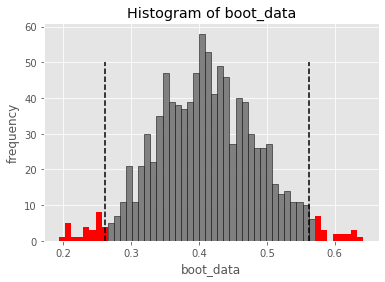

{'boot_data': [0.4759590488007053,
  0.44919718704470046,
  0.3980850896149004,
  0.3608391225914547,
  0.42894577490037555,
  0.5177598200697897,
  0.46535184538277985,
  0.5216242095347843,
  0.42673026232804023,
  0.6216133341671108,
  0.6044745340126498,
  0.38857443843664985,
  0.4355556135150298,
  0.29364374617109945,
  0.41421348130971936,
  0.4114498002537008,
  0.31347990476915477,
  0.48392564486073475,
  0.44698244282565014,
  0.41460889208093477,
  0.4515132516660145,
  0.3438899140025464,
  0.42707226369779505,
  0.383433889327101,
  0.30457351226240004,
  0.40081608397083457,
  0.454579907957104,
  0.4031289695497815,
  0.4441734506115651,
  0.4405413255045145,
  0.3747500922973863,
  0.29152425843473484,
  0.3906667841172,
  0.31474915236984913,
  0.43414578468348,
  0.4729840338595759,
  0.5017382678905644,
  0.4432384102167397,
  0.3638246107155503,
  0.29613859624205485,
  0.2521697111478147,
  0.4174575927235349,
  0.40600335444540026,
  0.4363476563528996,
  0.4246

In [24]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [25]:
5.4687657931866705e-08 < 0.0000002

True